In [2]:
import sys
import os
from pathlib import Path

# Define paths
if 'AIRFLOW_HOME' in os.environ:
    # Running in Airflow
    BASE_PATH = Path('/opt/airflow')
    DATA_PATH = BASE_PATH / 'base_dados' / 'Resultados'
    SPARK_CONFIG_PATH = BASE_PATH / 'spark_config'
else:
    # Running manually
    BASE_PATH = Path.cwd().parent
    DATA_PATH = BASE_PATH / 'base_dados' / 'Resultados'
    SPARK_CONFIG_PATH = BASE_PATH / 'spark_config'

# Add spark_config to path
sys.path.insert(0, str(SPARK_CONFIG_PATH))

print(f"Base Path: {BASE_PATH}")
print(f"Data Path: {DATA_PATH}")
print(f"Spark Config Path: {SPARK_CONFIG_PATH}")

Base Path: /home/mateus/Documentos/Faculdade/bancos2/TrabalhoSBD2
Data Path: /home/mateus/Documentos/Faculdade/bancos2/TrabalhoSBD2/base_dados/Resultados
Spark Config Path: /home/mateus/Documentos/Faculdade/bancos2/TrabalhoSBD2/spark_config


In [3]:
from config import SparkConfig, DataSchemas
from pyspark.sql import functions as F

# Create Spark session
spark_config = SparkConfig(app_name="BOP_Silver_Analysis")
spark = spark_config.create_spark_session()
spark_config.configure_for_banking_data()

print(f"Spark Version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

25/10/11 06:51:58 WARN Utils: Your hostname, mateus-730QED resolves to a loopback address: 127.0.1.1; using 192.168.1.166 instead (on interface wlo1)
25/10/11 06:51:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/11 06:51:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
INFO:config:Spark Session criada: BOP_Silver_Analysis
INFO:config:Spark UI disponível em: http://192.168.1.166:4040
25/10/11 06:52:00 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 06:52:00 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark 

Spark Version: 3.5.1
Spark UI: http://192.168.1.166:4040


In [4]:
# Load BOP data
bop_file = DATA_PATH / 'BOP.csv'
irfcl_file = DATA_PATH / 'IRFCL.csv'
iip_file = DATA_PATH / 'IIP.csv'
er_file = DATA_PATH / 'ER.csv'

df_bop = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(bop_file))

df_irfcl = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(irfcl_file))
df_iip = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(iip_file))
df_er = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(str(er_file))

print(f"Total records loaded: {df_bop.count():,}")
print(f"Total records loaded: {df_irfcl.count():,}")
print(f"Total records loaded: {df_iip.count():,}")
print(f"Total records loaded: {df_er.count():,}")

25/10/11 06:52:03 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 06:52:03 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 06:52:03 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 06:52:04 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 06:52:04 WARN SQLConf: The 

Total records loaded: 180,804
Total records loaded: 107,805
Total records loaded: 96,247
Total records loaded: 26,418


## Redimencionando BOP

In [5]:
indicadores_nome = {
    # (1) Sinal geral do país
    "CAB": "conta_corrente",
    "CABXEF": "corrente_limpa",
    "KAB": "conta_capital",
    "FAB": "conta_financeira",
    "FABXRRI": "financeira_mercado",
    "EO": "erros_omissões",

    # (2) Componentes do CAB
    "SF": "saldo_comercial",
    "GS": "bens_serviços",
    "IN1": "renda_primária",
    "IN2": "renda_secundária",

    # (3) Composição do financiamento
    "DXEF": "investimento_direto",
    "D_F5": "direto_acoes",
    "D_FL": "direto_divida",
    "PXEF": "portfólio_limpo",
    "P_F5": "portfólio_acoes",
    "P_F3": "portfólio_divida",
    "O_F4": "outros_emprestimos",
    "O_F2": "outros_depositos",
    "O_F81": "credito_comercial",

    # (4) Reservas
    "RUE": "uso_reservas",
    "R_F": "ativos_reservas"
}


accounting_entries = {
    "CD_T": "credito_entrada",
    "DB_T": "debito_saida",
    "NETCD_T": "saldo_liquido",
    "A_NFA_T": "ativos_aquisicao",
    "L_NIL_T": "passivos_incorporacao",
    "NNAFANIL_T": "conta_financeira",
    "A_T": "ativos_total",
    "L_T": "passivos_total"
}


In [6]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# Substitui 0 por nulo
bop_null = df_bop.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))

# Mapas de nomes amigáveis (se tiver)
indicadores_map = create_map([lit(x) for x in chain(*indicadores_nome.items())])    # Não estou usando no momento
contas_map = create_map([lit(x) for x in chain(*accounting_entries.items())])       # Não estou usando no momento

# Adiciona colunas de nomes e chave para pivot
bop_null = bop_null \
    .withColumn("INDICATOR_NOME", indicadores_map[col("INDICATOR")]) \
    .withColumn("ENTRY_NOME", contas_map[col("BOP_ACCOUNTING_ENTRY")]) \
    .withColumn("pivot_key", concat_ws("/BOP/", col("INDICATOR"), col("BOP_ACCOUNTING_ENTRY")))

# Pivot final
pivoted_BOP = bop_null.groupBy("COUNTRY", "UNIT", "FREQUENCY", "TIME_PERIOD") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_BOP.show()


25/10/11 06:52:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----+---------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|COUNTRY|UNIT|FREQUENCY|TIME_PERIOD|     CAB/BOP/NETCD_T|  CABXEF/BOP/NETCD_T|    DXEF/BOP/L_NIL_T|    D_F5/BOP/A_NFA_T|    D_F5/BOP/L_NIL_T|   

In [7]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# 1. Filtrar por tipo de transformação
er_null = df_er.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))

er_null = er_null.filter(col("TYPE_OF_TRANSFORMATION") == "EOP_RT")

# 2. Criar mapa de nomes legíveis (se quiser usar)
indicadores_map = create_map([lit(x) for x in chain(*indicadores_nome.items())])

# 3. Substituir zero por nulo
er_null = er_null.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))

# 4. Criar chave de pivot — pode usar nome legível ou o código
# Se quiser nome legível:
# er_null = er_null.withColumn("INDICATOR_NOME", indicadores_map[col("INDICATOR")])
#          .withColumn("pivot_key", col("INDICATOR_NOME"))

# Se quiser manter como está no código original (com nome técnico):
er_null = er_null.withColumn("pivot_key", concat_ws("/ER/", col("INDICATOR")))

# 5. Aplicar pivot
pivoted_ER = er_null.groupBy("COUNTRY", "TYPE_OF_TRANSFORMATION", "TIME_PERIOD", "FREQUENCY") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_ER.show()


+-------+----------------------+-----------+---------+------------------+-----------------+------------------+
|COUNTRY|TYPE_OF_TRANSFORMATION|TIME_PERIOD|FREQUENCY|           XDC_EUR|          XDC_USD|           XDC_XDR|
+-------+----------------------+-----------+---------+------------------+-----------------+------------------+
|    GBR|                EOP_RT|    2013-Q1|        Q|0.8467795265176558|0.661288189392937|0.9914008932106448|
|    IND|                EOP_RT|    2006-Q2|        Q|        57.3165605|           45.085| 66.69733891153965|
|    SAU|                EOP_RT|    2018-Q2|        Q|           4.37175|             3.75| 5.274647372241008|
|    URY|                EOP_RT|    2021-Q4|        Q|         50.621557|           44.695| 62.55484658352148|
|    CZE|                EOP_RT|    2005-Q4|        Q|        29.0064636|           24.588| 35.14278363776691|
|    PER|                EOP_RT|    2021-Q2|        Q|         4.5848472|            3.858| 5.503142411283582|
|

In [8]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# Substitui 0 por nulo
iip_null = df_iip.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))


# Adiciona colunas de nomes e chave para pivot
iip_null = iip_null \
    .withColumn("pivot_key", concat_ws("/IIP/", col("INDICATOR"), col("BOP_ACCOUNTING_ENTRY")))

# Pivot final
pivoted_IIP = iip_null.groupBy("COUNTRY", "UNIT", "FREQUENCY", "TIME_PERIOD") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_IIP.show()

+-------+----+---------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+
|COUNTRY|UNIT|FREQUENCY|TIME_PERIOD|           D/IIP/A_P|           D/IIP/L_P|        D_F5/IIP/A_P|        D_F5/IIP/L_P|        D_FL/IIP/A_P|        D_FL/IIP/L_P|    NIIP/IIP/NETAL_P|       O_F12/IIP/L_P|     O_F2_NV/IIP/A_P|     O_F2_NV/IIP/L_P|     O_F4_NV/IIP/A_P|     O_F4_NV/IIP/L_P|       O_F81/IIP/A_P|       O_F81/IIP/L_P|       O_FL1/IIP/A_P|     P_F3_MV/IIP/A_P|     P_F3_MV/IIP/L_P|    

In [9]:
from pyspark.sql.functions import col, when, concat_ws, lit, create_map, first
from itertools import chain

# 1. Filtrar por tipo de transformação
irfcl_null = df_irfcl.withColumn("value", when(col("value") == 0, None).otherwise(col("value")))

# Se quiser manter como está no código original (com nome técnico):
irfcl_null = irfcl_null.withColumn("pivot_key",  col("INDICATOR"))

# 5. Aplicar pivot
pivoted_IRFCL = irfcl_null.groupBy("COUNTRY", "SECTOR", "TIME_PERIOD", "FREQUENCY") \
    .pivot("pivot_key") \
    .agg(first("value"))

pivoted_IRFCL.show()

+-------+--------+-----------+---------+----------------------------+----------------------------+----------------------------+----------------------------+------------------------------------+----------------------------+-------------------------------+-----------------------------------------+----------------------------------------+-------------------------------------+--------------------------------------+------------------------------------+-------------------------------------+------------------------------------+---------------------------------+----------------------------------------+---------------------------------------+------------------------------------+--------------------+-------------------------------------+-------------------------------------+----------------------------+-----------------------------+-------------------------------+
|COUNTRY|  SECTOR|TIME_PERIOD|FREQUENCY|IRFCLDT1_IRFCL32_USD_IRFCL13|IRFCLDT1_IRFCL54_USD_IRFCL13|IRFCLDT1_IRFCL56_USD_IRFCL13|IRFCLD

In [10]:
# Primeiro join: BOP com ER
merged_df = pivoted_BOP.join(
    pivoted_ER,
    on=["COUNTRY", "TIME_PERIOD"],
    how="outer"
)

# Segundo join: resultado anterior com IIP
merged_df = merged_df.join(
    pivoted_IIP,
    on=["COUNTRY", "TIME_PERIOD"],
    how="outer"
)

# Terceiro join: resultado anterior com IRFCL
merged_df = merged_df.join(
    pivoted_IRFCL,
    on=["COUNTRY", "TIME_PERIOD"],
    how="outer"
)

merged_df.show()

+-------+-----------+----+---------+---------------+------------------+----------------+----------------+----------------+----------------+----------------+--------------+------------------+----------------------+-----------+-----------+--------------+------------+------------+---------------+------------+------------+---------------+---------------+----------------+----------------+-------------------+----------------+----------------+-------------------+-----------------+-----------------+--------------------+----------------+----------------+----------------+----------------+----------------+------------------+-----------+-----------+-----------+--------------+----------------------+---------+-----------------+-------+-----------------+----+---------+---------+---------+------------+------------+------------+------------+----------------+-------------+---------------+---------------+---------------+---------------+-------------+-------------+-------------+---------------+-----------

In [11]:
print(merged_df.count())
print(len(merged_df.columns))

6939
103


In [12]:
merged_df.dtypes

[('COUNTRY', 'string'),
 ('TIME_PERIOD', 'string'),
 ('UNIT', 'string'),
 ('FREQUENCY', 'string'),
 ('CAB/BOP/NETCD_T', 'double'),
 ('CABXEF/BOP/NETCD_T', 'double'),
 ('DXEF/BOP/L_NIL_T', 'double'),
 ('D_F5/BOP/A_NFA_T', 'double'),
 ('D_F5/BOP/L_NIL_T', 'double'),
 ('D_FL/BOP/A_NFA_T', 'double'),
 ('D_FL/BOP/L_NIL_T', 'double'),
 ('EO/BOP/NETCD_T', 'double'),
 ('FAB/BOP/NNAFANIL_T', 'double'),
 ('FABXRRI/BOP/NNAFANIL_T', 'double'),
 ('GS/BOP/CD_T', 'double'),
 ('GS/BOP/DB_T', 'double'),
 ('GS/BOP/NETCD_T', 'double'),
 ('IN1/BOP/CD_T', 'double'),
 ('IN1/BOP/DB_T', 'double'),
 ('IN1/BOP/NETCD_T', 'double'),
 ('IN2/BOP/CD_T', 'double'),
 ('IN2/BOP/DB_T', 'double'),
 ('IN2/BOP/NETCD_T', 'double'),
 ('KAB/BOP/NETCD_T', 'double'),
 ('O_F2/BOP/A_NFA_T', 'double'),
 ('O_F2/BOP/L_NIL_T', 'double'),
 ('O_F2/BOP/NNAFANIL_T', 'double'),
 ('O_F4/BOP/A_NFA_T', 'double'),
 ('O_F4/BOP/L_NIL_T', 'double'),
 ('O_F4/BOP/NNAFANIL_T', 'double'),
 ('O_F81/BOP/A_NFA_T', 'double'),
 ('O_F81/BOP/L_NIL_T', 'dou

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# Colunas-chave (ajuste se necessário)
KEY_COLS = ["COUNTRY", "TIME_PERIOD"]

# 1) Detectar todas as colunas numéricas (excluindo chaves e datas)
num_cols = [
    f.name for f in merged_df.schema.fields
    if isinstance(f.dataType, NumericType) and f.name not in KEY_COLS
]
print(f"[INFO] Foram detectadas {len(num_cols)} colunas numéricas.")

[INFO] Foram detectadas 93 colunas numéricas.


In [14]:
def _box_stats_for_metric(sdf, colname, rel_tol=1e-6):
    """
    Calcula estatísticas de boxplot (Tukey) no Spark e retorna
    um dict compatível com matplotlib.pyplot.bxp.
    """
    # Quantis aproximados (rápidos e escaláveis)
    q = sdf.approxQuantile(colname, [0.25, 0.5, 0.75], rel_tol)
    # Se a coluna for toda nula/vazia, devolve box vazio seguro
    if q is None or len(q) != 3:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    q1, med, q3 = q
    if q1 is None or q3 is None:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    # Limitar whiskers ao min/max dos pontos dentro do intervalo [low, high]
    inside = sdf.select(F.col(colname).alias("v")).where(
        F.col("v").isNotNull() & (F.col("v") >= low) & (F.col("v") <= high)
    )

    # Se não houver pontos "inside", caia para min/max gerais (evita erro)
    if inside.rdd.isEmpty():
        bounds = sdf.select(F.min(colname).alias("lo"), F.max(colname).alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi
    else:
        bounds = inside.select(F.min("v").alias("lo"), F.max("v").alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi

    return dict(med=med, q1=q1, q3=q3, whislo=lo, whishi=hi, fliers=[])

In [19]:
def _box_stats_for_metric(sdf, colname, rel_tol=1e-6, max_fliers=500):
    """
    Calcula estatísticas de boxplot (Tukey) no Spark e retorna
    um dict compatível com Axes.bxp, agora com 'fliers' preenchido.
    """
    q = sdf.approxQuantile(colname, [0.25, 0.5, 0.75], rel_tol)
    if not q or len(q) != 3:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    q1, med, q3 = q
    if q1 is None or q3 is None:
        return dict(med=None, q1=None, q3=None, whislo=None, whishi=None, fliers=[])

    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    inside = sdf.select(F.col(colname).alias("v")).where(
        F.col("v").isNotNull() & (F.col("v") >= low) & (F.col("v") <= high)
    )

    if inside.rdd.isEmpty():
        bounds = sdf.select(F.min(colname).alias("lo"), F.max(colname).alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi
    else:
        bounds = inside.select(F.min("v").alias("lo"), F.max("v").alias("hi")).collect()[0]
        lo = bounds.lo
        hi = bounds.hi

    # ---- calcular outliers (fliers) ----
    fliers_df = sdf.select(F.col(colname).alias("v")).where(
        F.col("v").isNotNull() & ((F.col("v") < low) | (F.col("v") > high))
    )
    # limite de segurança para não trazer milhões de pontos
    fliers_vals = (
        fliers_df
        .limit(max_fliers)              # cap opcional
        .rdd.map(lambda r: float(r[0])) # lista de floats
        .collect()
    )

    return dict(med=med, q1=q1, q3=q3, whislo=lo, whishi=hi, fliers=fliers_vals)


In [ ]:
import numpy as np

def _sample_values(sdf, colname, max_points=1000, frac=None):
    q = sdf.select(F.col(colname).alias("v")).where(F.col("v").isNotNull())
    if frac is not None:
        q = q.sample(withReplacement=False, fraction=frac, seed=42)
    return q.limit(max_points).rdd.map(lambda r: float(r[0])).collect()



def plot_boxplots_by_country(sdf, country, metrics=None, max_metrics=5, rel_tol=1e-6, title_suffix="ANTES"):
    """
    Plota boxplots para TODAS (ou um subconjunto) das colunas numéricas de um país.
    - sdf: DataFrame Spark (ex.: merged_df)
    - country: string (ex.: "BRA")
    - metrics: lista de colunas numéricas (default: todas detectadas)
    - max_metrics: limite para não poluir o gráfico
    - rel_tol: tolerância do approxQuantile
    - title_suffix: texto no título ("ANTES", "DEPOIS", etc.)
    """
    if metrics is None:
        metrics = num_cols
    metrics = metrics[:max_metrics]

    # Recorte por país e remover linhas totalmente nulas nas colunas analisadas
    base = sdf.filter(F.col("COUNTRY") == country)
    # (opcional) se quiser garantir que haja valores: base = base.na.drop(subset=metrics)

    # Calcula as stats no Spark e traz só os números
    stats = [_box_stats_for_metric(base, m, rel_tol=rel_tol) for m in metrics]

    # Caso alguma métrica não tenha dados, substitui por um box "vazio" (evita erro do bxp)
    cleaned_stats = []
    cleaned_labels = []
    for m, s in zip(metrics, stats):
        if None in (s["q1"], s["q3"], s["med"], s["whislo"], s["whishi"]):
            # pula métricas sem dados válidos
            continue
        cleaned_stats.append(s)
        cleaned_labels.append(m)

    if not cleaned_stats:
        print(f"[WARN] Sem dados numéricos válidos para {country} nas métricas selecionadas.")
        return


    fig_w = max(8, len(cleaned_stats)*0.9)
    fig, ax = plt.subplots(figsize=(fig_w, 6))

    # usar o método do eixo em vez de plt.bxp
    ax.bxp(cleaned_stats, showfliers=True)

    # Depois do ax.bxp(...):
    for i, m in enumerate(cleaned_labels, start=1):
        vals = _sample_values(base, m, max_points=800)  # coleta amostra
        if not vals: 
            continue
        x = np.random.normal(loc=i, scale=0.04, size=len(vals))  # jitter ao redor da x=i
        ax.scatter(x, vals, alpha=0.35, s=10)  # pontos de todos os valores (amostrados)

    ax.set_xticks(range(1, len(cleaned_labels) + 1))
    ax.set_xticklabels(cleaned_labels, rotation=45, ha="right")
    ax.set_title(f"Boxplots ({title_suffix}) — {country}")

    fig.tight_layout()
    plt.show()




25/10/11 07:48:02 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 07:48:02 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 07:48:04 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 07:48:06 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 07:48:08 WARN SQLConf: The 

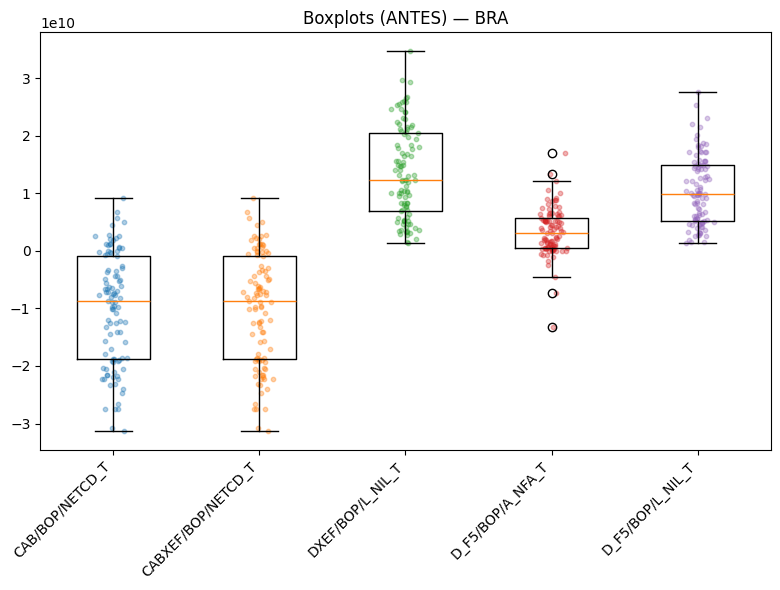

In [ ]:

plot_boxplots_by_country(merged_df, country="BRA", title_suffix="ANTES")


In [24]:
from pyspark.sql import functions as F

def build_iqr_thresholds(sdf, group_cols=["COUNTRY"], metrics=None, accuracy=200, whisker=1.5):
    """
    Calcula Q1/Q3/IQR/low/high por grupo (ex.: por COUNTRY) para várias métricas,
    usando percentile_approx (agregador nativo do Spark).
    Retorna um DF com colunas: group_cols + para cada métrica: __q1, __q3, __iqr, __low, __high.
    """
    if metrics is None:
        # use sua lista já detectada de numéricas
        metrics = [f.name for f in sdf.schema.fields if isinstance(f.dataType, NumericType) and f.name not in ["COUNTRY","TIME_PERIOD"]]

    # agrega Q1 e Q3 por grupo
    agg_exprs = []
    for c in metrics:
        agg_exprs += [
            F.expr(f"percentile_approx({c}, 0.25, {accuracy})").alias(f"{c}__q1"),
            F.expr(f"percentile_approx({c}, 0.75, {accuracy})").alias(f"{c}__q3"),
        ]

    th = sdf.groupBy(*group_cols).agg(*agg_exprs)

    # calcula IQR e limites, com guardas para casos degenerados (iqr nulo/zero)
    for c in metrics:
        q1 = F.col(f"{c}__q1")
        q3 = F.col(f"{c}__q3")
        iqr = (q3 - q1)
        th = th.withColumn(f"{c}__iqr", iqr) \
               .withColumn(
                   f"{c}__low",
                   F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q1 - whisker * iqr)
               ).withColumn(
                   f"{c}__high",
                   F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q3 + whisker * iqr)
               )
    return th


In [27]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

def build_iqr_thresholds(sdf, group_cols=["COUNTRY"], metrics=None, accuracy=200, whisker=1.5):
    """
    Calcula Q1/Q3/IQR/low/high por grupo para várias métricas
    usando percentile_approx em API de coluna (seguro p/ nomes com caracteres especiais).
    """
    if metrics is None:
        metrics = [
            f.name for f in sdf.schema.fields
            if isinstance(f.dataType, NumericType) and f.name not in ["COUNTRY","TIME_PERIOD"]
        ]

    # agrega Q1 e Q3 por grupo usando a API de coluna
    agg_exprs = []
    for c in metrics:
        agg_exprs += [
            F.percentile_approx(F.col(c), 0.25, accuracy).alias(f"{c}__q1"),
            F.percentile_approx(F.col(c), 0.75, accuracy).alias(f"{c}__q3"),
        ]

    th = sdf.groupBy(*group_cols).agg(*agg_exprs)

    # calcula IQR e limites com guardas
    for c in metrics:
        q1 = F.col(f"{c}__q1")
        q3 = F.col(f"{c}__q3")
        iqr = (q3 - q1)
        th = (
            th.withColumn(f"{c}__iqr", iqr)
              .withColumn(
                  f"{c}__low",
                  F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q1 - whisker * iqr)
              )
              .withColumn(
                  f"{c}__high",
                  F.when(q1.isNull() | q3.isNull() | (iqr <= 0), F.lit(None)).otherwise(q3 + whisker * iqr)
              )
        )
    return th


In [28]:
from pyspark.sql.types import NumericType

def nullify_outliers_all(sdf, group_cols=["COUNTRY"], metrics=None, whisker=1.5, accuracy=200):
    """
    Substitui por NULL os outliers (v < low ou v > high) em TODAS as métricas,
    por grupo (ex.: por COUNTRY). Mantém valores dentro do intervalo e nulos originais.
    """
    if metrics is None:
        metrics = [f.name for f in sdf.schema.fields if isinstance(f.dataType, NumericType) and f.name not in ["COUNTRY","TIME_PERIOD"]]

    # calcula limiares e faz join
    th = build_iqr_thresholds(sdf, group_cols, metrics, accuracy=accuracy, whisker=whisker)
    df = sdf.join(th, on=group_cols, how="left")

    # aplica nulificação por métrica
    out = df
    schema_map = {f.name: f.dataType for f in sdf.schema.fields}  # para cast de NULL seguro
    for c in metrics:
        lo = F.col(f"{c}__low")
        hi = F.col(f"{c}__high")
        # se low/high indisponíveis (IQR==0 ou quantis nulos), não mexe na coluna
        out = out.withColumn(
            c,
            F.when(lo.isNull() | hi.isNull(), F.col(c)) \
             .when(F.col(c).isNull(), F.col(c)) \
             .when((F.col(c) < lo) | (F.col(c) > hi), F.lit(None).cast(schema_map[c])) \
             .otherwise(F.col(c))
        )

    # remove colunas auxiliares
    aux_cols = [col for col in out.columns if col.endswith(("__q1","__q3","__iqr","__low","__high"))]
    return out.drop(*aux_cols)


In [29]:
# nulificar outliers por país (todas as métricas numéricas)
clean_df = nullify_outliers_all(merged_df, group_cols=["COUNTRY"], whisker=1.5, accuracy=200)

# opcional: verificar quantos valores viraram NULL em uma métrica
m = "DXEF/BOP/L_NIL_T"  # exemplo
before_nulls = merged_df.where(F.col(m).isNull()).count()
after_nulls  = clean_df.where(F.col(m).isNull()).count()
print(f"{m}: nulos antes={before_nulls}, depois={after_nulls}, inseridos={after_nulls - before_nulls}")


DXEF/BOP/L_NIL_T: nulos antes=827, depois=1158, inseridos=331


25/10/11 08:29:05 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 08:29:10 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 08:29:17 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 08:29:19 WARN SQLConf: The SQL config 'spark.sql.adaptive.coalescePartitions.minPartitionNum' has been deprecated in Spark v3.2 and may be removed in the future. Use 'spark.sql.adaptive.coalescePartitions.minPartitionSize' instead.
25/10/11 08:29:22 WARN SQLConf: The 

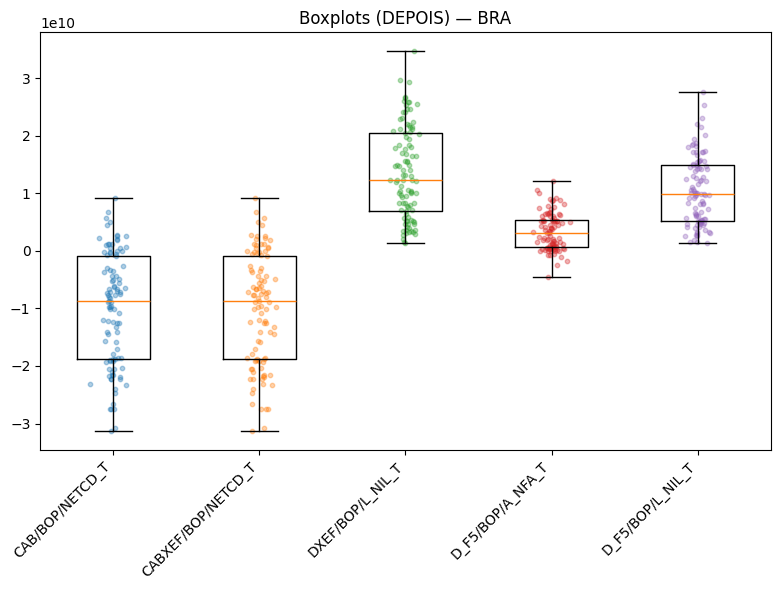

In [30]:
plot_boxplots_by_country(clean_df, country="BRA", title_suffix="DEPOIS")


In [33]:
# --- imports necessários ---
import math
from typing import Iterable, Dict, Any, List

from postgres_helper import get_postgres_conn
from cliente_postgres import ClientPostgresDB

# Se precisar:
# from pyspark.sql import functions as F
# from pyspark.sql import DataFrame as SparkDataFrame

def _sanitize_column_name(name: str) -> str:
    """
    Saneia nomes de coluna para PostgreSQL sem aspas:
    - minúsculas
    - troca qualquer caractere não [a-z0-9_] por "_"
    - comprime repetições de "_" e remove "_" nas pontas
    """
    import re
    s = name.lower()
    s = re.sub(r"[^a-z0-9_]+", "_", s)
    s = re.sub(r"_{2,}", "_", s)
    s = s.strip("_")
    return s or "col"

def sanitize_columns_spark(df, reserved: List[str] = None):
    """
    Renomeia todas as colunas do Spark DF de modo seguro p/ Postgres (sem aspas).
    Mantém 'country' e 'time_period' se existirem (ou converte pra minúsculas).
    """
    reserved = set(reserved or [])
    renames = {}
    for c in df.columns:
        new_c = _sanitize_column_name(c)
        if c.lower() in {"country", "time_period"}:
            new_c = c.lower()
        # evita colisão: se já existe, anexa índice
        base = new_c
        i = 2
        while new_c in renames.values():
            new_c = f"{base}_{i}"
            i += 1
        renames[c] = new_c

    out = df
    for old, new in renames.items():
        if old != new:
            out = out.withColumnRenamed(old, new)
    return out, renames

def _row_to_dict(row) -> Dict[str, Any]:
    """
    Converte Spark Row -> dict "puro" (recursivo).
    """
    d = row.asDict(recursive=True)
    # Converte numpy types, Decimal etc. para tipos Python padrão quando necessário
    try:
        import numpy as np
        for k, v in list(d.items()):
            if isinstance(v, np.generic):
                d[k] = v.item()
    except Exception:
        pass
    return d

def write_spark_to_postgres_in_batches(
    sdf,
    table_name: str,
    schema: str = "raw",
    conflict_fields: List[str] = None,  # ex.: ["country","time_period"]
    primary_key: List[str] = None,      # ex.: ["country","time_period"]
    batch_size: int = 10_000,
    sanitize_columns: bool = True,
) -> None:
    """
    Envia um Spark DF ao Postgres chamando ClientPostgresDB.insert_data() em lotes.

    - Sem toPandas (usa toLocalIterator)
    - Cria a tabela automaticamente (via insert_data -> create_table_if_not_exists)
    - Pode fazer UPSERT se conflict_fields for fornecido
    """
    # 1) Colunas: sanitizar (recomendado se você tem nomes com "/", espaços, etc.)
    sdf_out = sdf
    rename_map = {}
    if sanitize_columns:
        sdf_out, rename_map = sanitize_columns_spark(sdf_out)

    # 2) Conexão
    conn_str = get_postgres_conn()
    client = ClientPostgresDB(conn_str)

    # 3) Iterar em lotes
    batch: List[Dict[str, Any]] = []
    count = 0

    for row in sdf_out.toLocalIterator():  # stream sem explodir memória
        batch.append(_row_to_dict(row))
        if len(batch) >= batch_size:
            client.insert_data(
                data=batch,
                table_name=table_name,
                conflict_fields=conflict_fields,
                primary_key=primary_key,
                schema=schema,
            )
            count += len(batch)
            batch.clear()

    if batch:
        client.insert_data(
            data=batch,
            table_name=table_name,
            conflict_fields=conflict_fields,
            primary_key=primary_key,
            schema=schema,
        )
        count += len(batch)

    print(f"[OK] Inseridos {count} registros em {schema}.{table_name}")
    if rename_map:
        print("[INFO] Renomeações aplicadas (Spark -> Postgres):")
        for k, v in rename_map.items():
            if k != v:
                print(f"  - {k} -> {v}")


ModuleNotFoundError: No module named 'psycopg2'

In [ ]:
# Exemplo de chamada
write_spark_to_postgres_in_batches(
    clean_df,
    table_name="bop_clean",         # escolha o nome da tabela
    schema="raw",                   # ou "silver"/"gold", como preferir
    conflict_fields=["country","time_period"],  # para UPSERT
    primary_key=["country","time_period"],      # cria PK se a tabela for nova
    batch_size=10_000,
    sanitize_columns=True,          # recomendo True se você tiver nomes com "/"
)
